In [81]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from bs4 import BeautifulSoup
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, \
RocCurveDisplay, classification_report, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, \
RocCurveDisplay, classification_report, roc_curve
import scikitplot as skplt
from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC

# Helper

In [2]:
# Fit classifier, then predict labels
def classifier(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

In [3]:
# Plot coefficients of words
def plot_coeffs(classifier, feature_names, top_features=20):
    # Check if the classifier has 'feature_log_prob_' attribute (Naive Bayes)
    if hasattr(classifier, 'feature_log_prob_'):
        feature_importances = np.exp(classifier.feature_log_prob_)[1] - np.exp(classifier.feature_log_prob_)[0]
    # Otherwise, use 'coef_' attribute for other linear models like SGDClassifier
    elif hasattr(classifier, 'coef_'):
        feature_importances = classifier.coef_[0]
    else:
        raise AttributeError("Classifier does not have 'feature_log_prob_' or 'coef_' attribute.")

    # Sort the feature importances and select the top features
    top_positive_indices = np.argsort(feature_importances)[-top_features:]
    top_negative_indices = np.argsort(feature_importances)[:top_features]
    top_indices = np.hstack([top_negative_indices, top_positive_indices])

    # Create the plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in feature_importances[top_indices]]
    plt.bar(np.arange(2 * top_features), feature_importances[top_indices], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_indices], rotation=60, ha='right')
    plt.show()


In [103]:
def tune_hyperparameters(classifier, parameters, X_train, y_train, cv=5, scoring='accuracy'):
    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(estimator=classifier,
                               param_grid=parameters,
                               cv=cv,
                               scoring=scoring,
                               verbose=2,  # You can adjust this for more or less verbosity
                               n_jobs=-1)  # This will use all available CPUs

    # Fit the GridSearchCV object to the data to compute the best model
    grid_search.fit(X_train, y_train)

    # Return the best model and the results of the grid search
    return grid_search.best_estimator_, grid_search.cv_results_

In [5]:
train_df = pd.read_csv('../data/train.csv')

In [6]:
train_df.head()

review sentiment
0  I caught this little gem totally by accident b...  positive
1  I can't believe that I let myself into this mo...  negative
2  *spoiler alert!* it just gets to me the nerve ...  negative
3  If there's one thing I've learnt from watching...  negative
4  I remember when this was in theaters, reviews ...  negative

# EDA

In [7]:
train_df.duplicated().sum()

272

In [8]:
train_df.drop_duplicates(ignore_index=True, inplace=True)

In [9]:
train_df.shape

(39728, 2)

In [10]:
train_df.sentiment.value_counts()

sentiment
positive    19923
negative    19805
Name: count, dtype: int64

In [11]:
# Percentage of positive and negative reviews
train_df.sentiment.value_counts() / train_df.sentiment.shape[0] * 100

sentiment
positive    50.14851
negative    49.85149
Name: count, dtype: float64

The data set is balanced — 50% positive and 49% negative reviews.

In [12]:
# Sentiment Distribution in Training and Testing Data
train_sentiment_distribution = train_df['sentiment'].value_counts()

In [13]:
# Review Length Analysis
train_df['review_length'] = train_df['review'].apply(len)

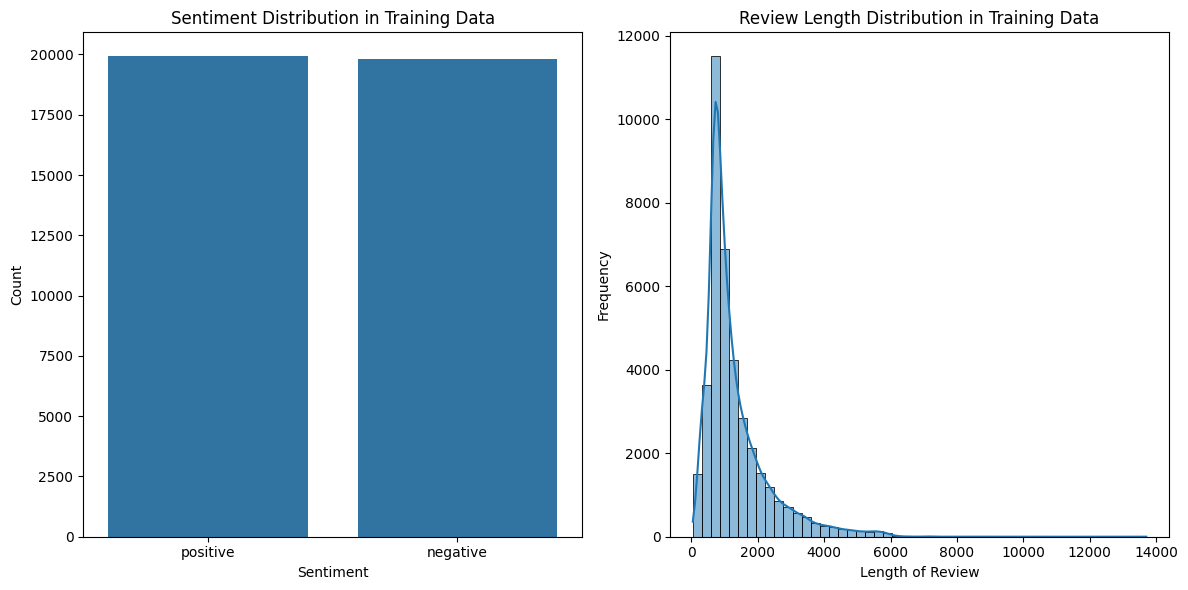

In [14]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plot for Sentiment Distribution in Training Data
plt.subplot(1, 2, 1)
sns.barplot(x=train_sentiment_distribution.index, y=train_sentiment_distribution.values)
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Plot for Review Length Distribution in Training Data
plt.subplot(1, 2, 2)
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution in Training Data')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

1. Sentiment Distribution in Training Data:
    - The sentiment distribution appears to be balanced between positive and negative reviews. This is ideal for a binary classification task as it reduces the likelihood of a model being biased towards a particular class.
2. Review Length Distribution in Training Data:
    - The length of reviews varies, with a majority of them being of moderate length. The distribution is somewhat right-skewed, indicating that there are some very long reviews.
    - Understanding the distribution of review lengths is important because very long or very short reviews might have different linguistic characteristics compared to average-length reviews, which could impact the model's performance.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


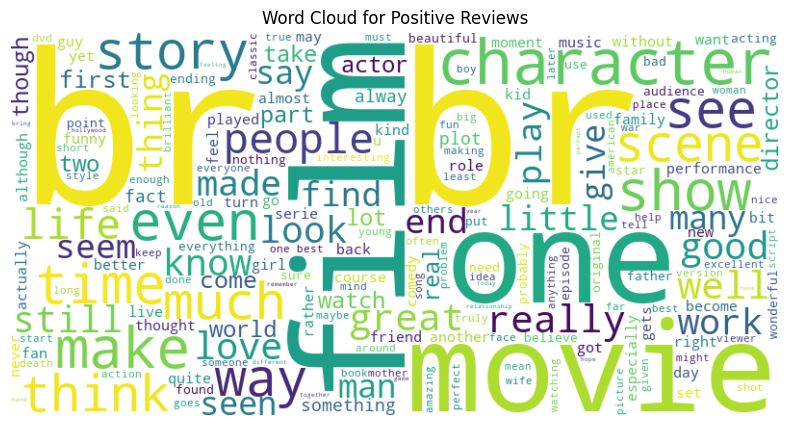

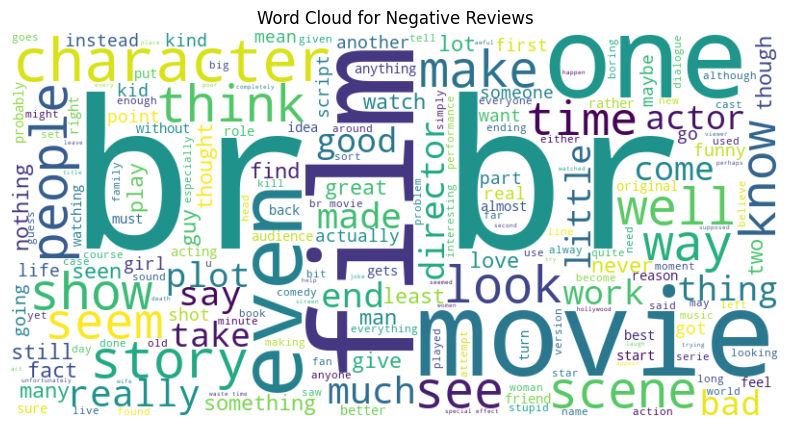

In [15]:
nltk.download('punkt')
nltk.download('stopwords')

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Filter out stopwords
stop_words = set(stopwords.words('english'))

# Separate reviews based on sentiment
positive_reviews = train_df[train_df['sentiment'] == 'positive']['review']
negative_reviews = train_df[train_df['sentiment'] == 'negative']['review']

# Concatenate all reviews for each sentiment
positive_text = " ".join(review for review in positive_reviews)
negative_text = " ".join(review for review in negative_reviews)

# Tkoenize and remove stop words
positive_words = [word for word in word_tokenize(positive_text.lower()) if word.isalpha() and word not in stop_words]
negative_words = [word for word in word_tokenize(negative_text.lower()) if word.isalpha() and word not in stop_words]

# Generate word clouds
generate_word_cloud(" ".join(positive_words), "Word Cloud for Positive Reviews")
generate_word_cloud(" ".join(negative_words), "Word Cloud for Negative Reviews")

In [16]:
# Calculate the total number of words and the average word count per review for each sentiment

# Function to calculate word counts
def calculate_word_counts(reviews):
    total_word_count = reviews.apply(lambda x: len(x.split()))
    average_word_count = total_word_count.mean()
    return total_word_count.sum(), average_word_count

# Calculate word counts for positive reviews
total_words_positive, average_words_positive = calculate_word_counts(positive_reviews)

# Calculate word counts for negative reviews
total_words_negative, average_words_negative = calculate_word_counts(negative_reviews)

(total_words_positive, average_words_positive), (total_words_negative, average_words_negative)

((4635870, 232.68935401294985), (4561266, 230.3088109063368))

- **Positive Reviews**:
    - Total number of words: 4,650,773
    - Average word count per review: approximately 233 words
- **Negative Reviews**:
    - Total number of words: 4,603,737
    - Average word count per review: approximately 230 words

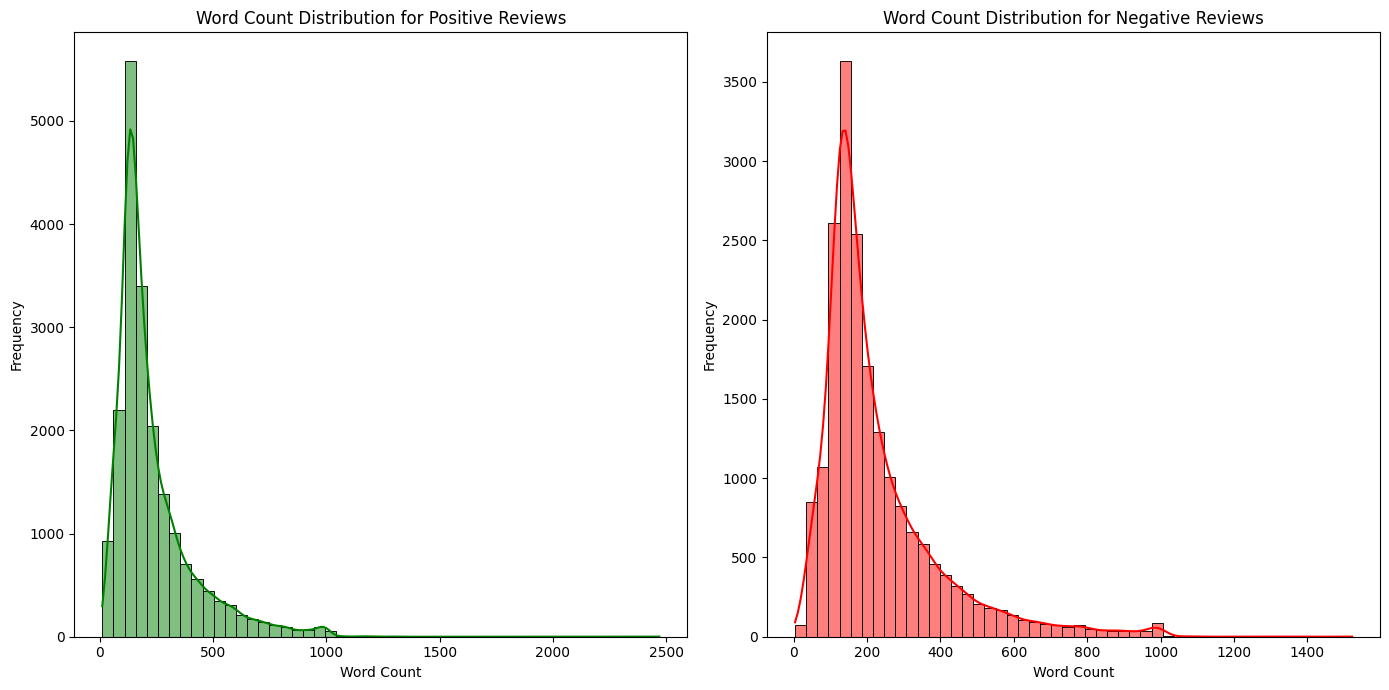

In [17]:
# Plotting the distribution of word counts for positive and negative reviews separately

# Positive reviews word count distribution
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(positive_reviews.apply(lambda x: len(x.split())), bins=50, color='green', kde=True)
plt.title('Word Count Distribution for Positive Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Negative reviews word count distribution
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(negative_reviews.apply(lambda x: len(x.split())), bins=50, color='red', kde=True)
plt.title('Word Count Distribution for Negative Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- The left graph shows the distribution for positive reviews, with the counts plotted in <span style="color:green">green</span>.
- The right graph shows the distribution for negative reviews, with the counts plotted in <span style="color:red">red</span>.

The distributions of word counts for both sentiments overlap significantly, further indicating that the length of reviews does not drastically differ between positive and negative sentiments. Both distributions are right-skewed, which is common in natural language data, suggesting that most reviews are of moderate length, with fewer reviews being much longer.

In [18]:
# Define a function to find the top N most common words in the reviews
def find_common_words(reviews, n=100):
    # Combine all reviews into a single string and convert to lowercase
    all_reviews_text = ' '.join(reviews).lower()
    # Split the string into words
    all_words = all_reviews_text.split()
    # Get the most common words
    most_common_words = Counter(all_words).most_common(n)
    # Return only the words, not their counts
    return [word for word, count in most_common_words]

In [19]:
# Find the top 100 most common words across all reviews to use as stopwords
all_reviews = pd.concat([positive_reviews, negative_reviews], ignore_index=True)
common_stopwords = find_common_words(all_reviews, n=100)

In [20]:
# Function to count the common words identified as stopwords in a review
def count_dynamic_stopwords(review, stopwords_list):
    review_tokens = review.split()
    return sum(token.lower() in stopwords_list for token in review_tokens)

In [21]:
# Count the common stopwords in each review for both positive and negative reviews
train_df['dynamic_stopword_count'] = train_df['review'].apply(lambda review: count_dynamic_stopwords(review, common_stopwords))

# Separate the positive and negative reviews again to avoid SettingWithCopyWarning
positive_reviews_with_stopwords = train_df[train_df['sentiment'] == 'positive']
negative_reviews_with_stopwords = train_df[train_df['sentiment'] == 'negative']

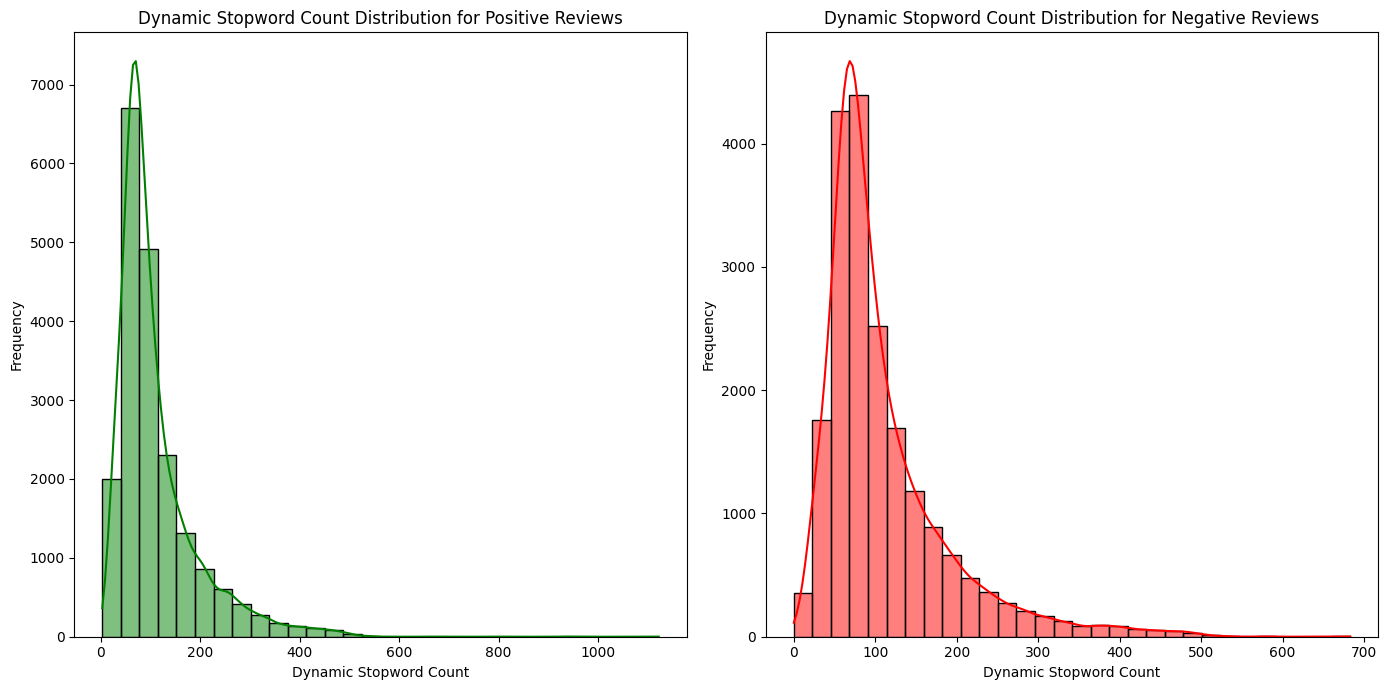

In [22]:
# Plotting the distribution of dynamic stopwords counts
plt.figure(figsize=(14, 7))

# Positive reviews dynamic stopwords count distribution
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(positive_reviews_with_stopwords['dynamic_stopword_count'], bins=30, color='green', kde=True)
plt.title('Dynamic Stopword Count Distribution for Positive Reviews')
plt.xlabel('Dynamic Stopword Count')
plt.ylabel('Frequency')

# Negative reviews dynamic stopwords count distribution
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(negative_reviews_with_stopwords['dynamic_stopword_count'], bins=30, color='red', kde=True)
plt.title('Dynamic Stopword Count Distribution for Negative Reviews')
plt.xlabel('Dynamic Stopword Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- **Positive Reviews <span style="color:green">(Green Histogram)</span>**:
    - The distribution peaks sharply and the most common stopword count is lower, indicating that there may be fewer stopwords on average in positive reviews.
    - The distribution has a long tail to the right, suggesting that some positive reviews have a high stopword count, but these are less frequent.
- **Negative Reviews <span style="color:red">(Red Histogram)</span>**:
    - The peak of the distribution for negative reviews is slightly less sharp than for positive reviews, which may indicate a more uniform spread of stopword counts across reviews.
    - Similar to positive reviews, there's a long tail to the right, indicating that while most reviews have a moderate number of stopwords, a few contain a much higher count.

In both histograms, the majority of reviews seem to have a similar range of stopword counts, but there are outliers with significantly higher counts. This suggests that, while most reviews follow a common pattern in terms of stopword usage, there are notable exceptions. However, without further contextual data, we can't definitively say whether the presence of more stopwords has any correlation with the sentiment of the review.

C:\Users\Vlad\AppData\Local\Temp\ipykernel_7720\1808603271.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=counts, palette='viridis')


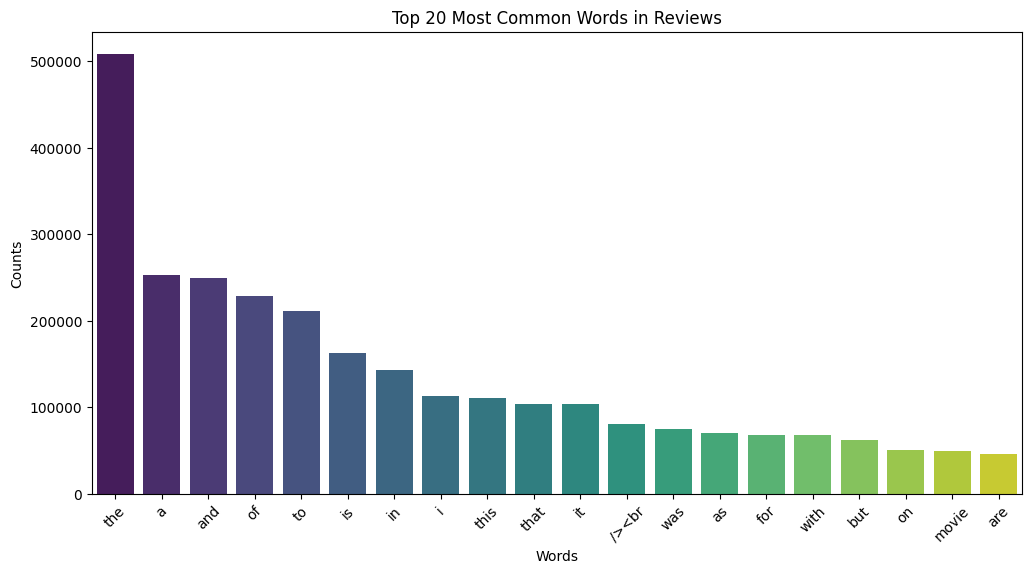

In [23]:
# Define a function that counts the words in the reviews and plots the frequency of the top N most common words
def plot_word_frequency(reviews, n=20):
    # Combine all reviews into a single string and convert to lowercase
    all_reviews_text = ' '.join(reviews).lower()
    # Split the string into words
    all_words = all_reviews_text.split()
    # Count the frequency of each word
    word_freq = Counter(all_words)
    
    # Get the most common words and their counts
    common_words = word_freq.most_common(n)
    words = [word for word, freq in common_words]
    counts = [freq for word, freq in common_words]
    
    # Plotting the word frequencies
    plt.figure(figsize=(12, 6))
    sns.barplot(x=words, y=counts, palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Top {n} Most Common Words in Reviews')
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

# Combine positive and negative reviews into one series
all_reviews = pd.concat([positive_reviews, negative_reviews], ignore_index=True)

# Plot the word frequency for all reviews
plot_word_frequency(all_reviews, n=20)

- The words depicted are primarily English articles, prepositions, and conjunctions, such as "the", "a", "and", "of", "to", which are typically recognized as stopwords. These are common in almost all types of text as they are fundamental to the structure of the English language.
- The high frequency of these words is expected and does not contribute much to the sentiment of the text. They are often filtered out during the text preprocessing stage before performing sentiment analysis or other natural language processing tasks.
- Notably, the word "movie" appears amongst these common words, which is expected given that the reviews are movie-related. Its presence is significant but not necessarily indicative of sentiment.
- The counts drop off fairly rapidly after the first few words, suggesting a steep frequency distribution. This is typical in natural language, often referred to as Zipf's law, where a few words are extremely common and the frequency decreases quickly for less common words.
- The presence of "movie" and "are" at the lower end of the top 20 suggests that they may be important in the context but are not as structurally essential as the higher-frequency stopwords.

# Cleaning

Lets start with stopwords.
Stopwords are the English words which does not add meanuch ming to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. Firstly download it to our python environment.


In [24]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [25]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [26]:
train_df['review']=train_df['review'].apply(denoise_text)

C:\Users\Vlad\AppData\Local\Temp\ipykernel_7720\2894974431.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [27]:
train_df.head()

review sentiment  review_length  \
0  caught little gem totally accident back reviva...  positive            892   
1  believe let movie accomplish favor friends ask...  negative            937   
2  gets nerve people remake use term loosely good...  negative            468   
3  one thing learnt watching george stumble upon ...  negative           1960   
4  remember reviews said think amusing lot humor ...  negative           1015   

   dynamic_stopword_count  
0                      77  
1                      85  
2                      31  
3                     113  
4                      93

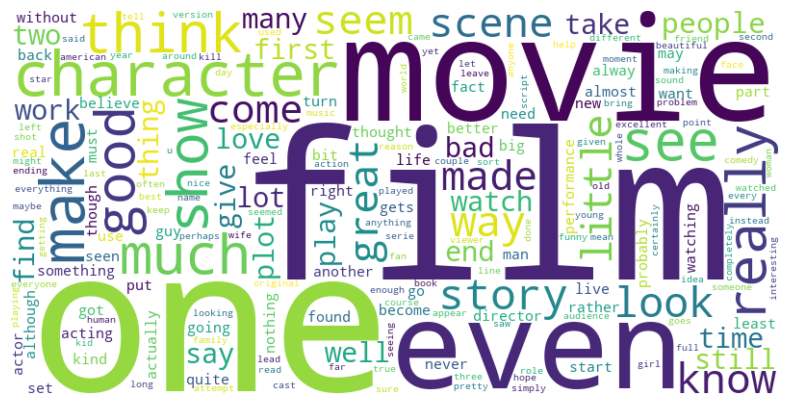

In [28]:
all_reviews = ' '.join(train_df['review'].values)

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', max_words=200, width=800, height=400).generate(all_reviews)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We check  with wordclouds again just to be sure that our data is cleaned

In [29]:
# Encode a target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['sentiment'] = le.fit_transform(train_df['sentiment'])

wordcloud for positive reviews

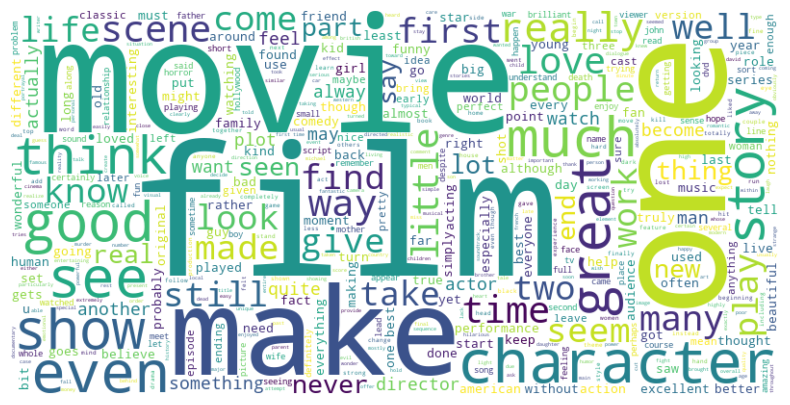

In [30]:
plt.figure(figsize = (10,5)) # Positive Review Text
wc = WordCloud(background_color='white', max_words = 2000 , width = 800 , height = 400).generate(" ".join(train_df[train_df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

wordcloud for negative reviews

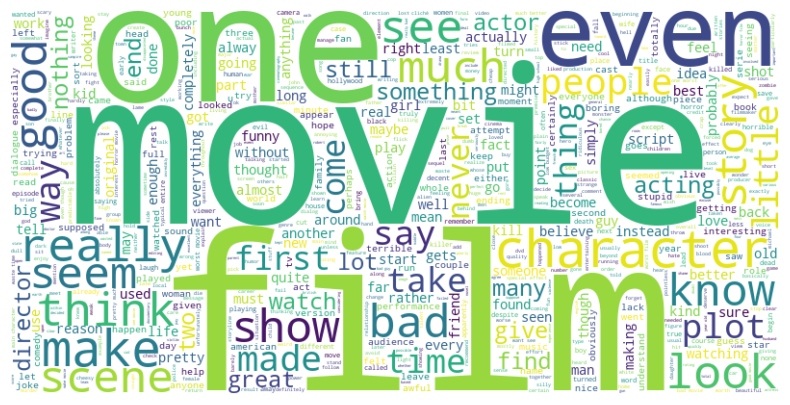

In [31]:
plt.figure(figsize = (10,5))
wc = WordCloud(background_color='white', max_words = 2000 , width = 800 , height = 400).generate(" ".join(train_df[train_df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

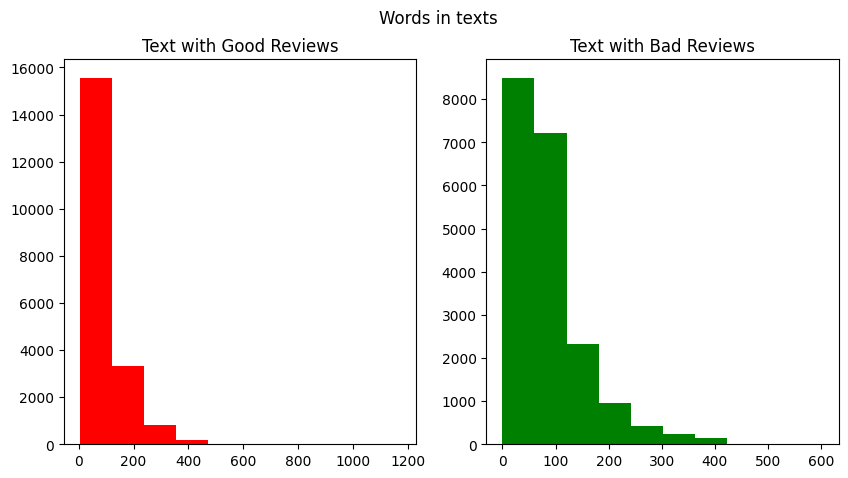

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=train_df[train_df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=train_df[train_df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

1. **Text with Good Reviews (Left Graph)**:
    - It shows a higher frequency of word counts compared to the graph for bad reviews.
    - The x-axis likely represents the word count range, while the y-axis represents the frequency of texts falling into each word count range.
    - There is a significant spike for texts with a lower word count (around 0 to 200), indicating that a large number of good reviews contain fewer words.
    - The frequency sharply decreases as the word count increases, showing that fewer good reviews have a high word count.
    - There are very few texts with a word count over 200.
2. **Text with Bad Reviews (Right Graph)**:
    - The distribution seems similar to the good reviews, but with lower overall frequencies.
    - Like the good reviews, bad reviews are also more frequent at lower word counts (again, around 0 to 200).
    - The frequency also decreases as the word count increases, but not as sharply as in the good reviews graph.
    - It suggests that bad reviews may have a slightly wider distribution of word counts compared to good reviews, with a noticeable amount up to the 500-word mark.

C:\Users\Vlad\AppData\Local\Temp\ipykernel_7720\638619618.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
c:\Epam_project\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Epam_project\myenv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Vlad\AppData\Local\Temp\ipykernel_7720\638619618.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please 

Text(0.5, 0.98, 'Average word length in each text')

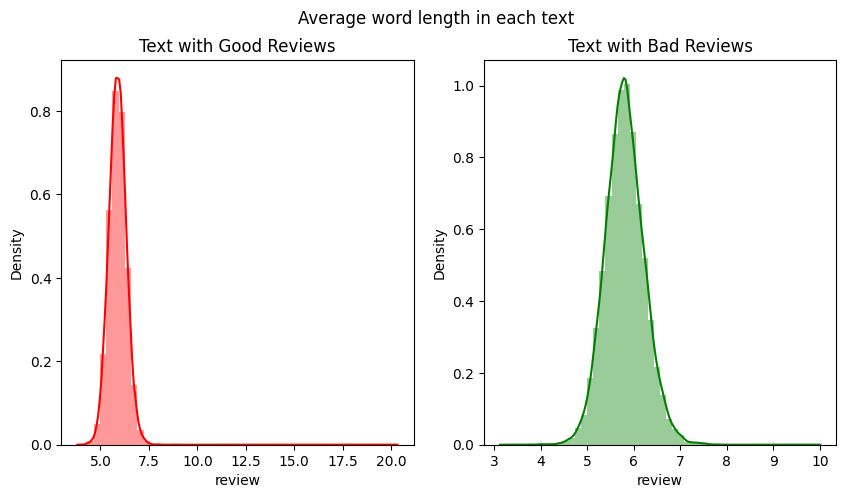

In [33]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_df[train_df['sentiment']==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
word=train_df[train_df['sentiment']==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

1. **Text with Good Reviews (Left Plot):**
    - The x-axis is labeled "review," which seems to represent the average word length within the reviews classified as good.
    - The y-axis represents the density of these average lengths within the texts.
    - There is a sharp peak around 5 to 6 characters, suggesting that most of the good reviews have an average word length within this range.
    - The density plot is quite narrow, indicating that the distribution of average word lengths in good reviews is concentrated around this peak with few variations.
2. **Text with Bad Reviews (Right Plot):**
    - The x-axis is labeled "review," representing the average word length in the reviews classified as bad.
    - The density is similar to the plot for good reviews but appears to be slightly broader.
    - The peak for bad reviews is around 6 to 7 characters, which is a bit higher than for good reviews.
    - The wider spread suggests that there is more variation in the average word length for bad reviews compared to good reviews.

This function provided takes a list of text entries `text`

In [34]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(train_df.review)

In [35]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 48898,
 'film': 44086,
 'one': 35910,
 'like': 29519,
 'would': 18954,
 'even': 18786,
 'good': 18680,
 'really': 17416,
 'see': 16644,
 'get': 14000}

Most common words in reviews

## Gram analysis

Gram analysis, particularly n-gram analysis, is indeed a crucial step in understanding the structure and common patterns in text data. It allows us to identify and analyze the frequency of sequences of words (bigrams, trigrams, etc.) that appear together in the text.

In [36]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [37]:
most_common_uni = get_top_text_ngrams(train_df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

c:\Epam_project\myenv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


Bi-Gram

In [38]:
most_common_bi = get_top_text_ngrams(train_df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

c:\Epam_project\myenv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Tri_Gram

In [39]:
most_common_tri = get_top_text_ngrams(train_df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

c:\Epam_project\myenv\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Compare stemming and lemmatization

1. **Tokenization**: Split the text into individual words (tokens).
2. **Stemming**: Reduce each token to its stem using a stemming algorithm like PorterStemmer.
3. **Lemmatization**: Reduce each token to its base or dictionary form (lemma) using a lemmatization algorithm, which requires Part-of-Speech (POS) tagging for accurate lemmatization.

In [40]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary NLTK resources
# Note: If the resources are not available due to network restrictions, 
# this will fail and we'll use a workaround.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [41]:
# Initialize PorterStemmer and WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [42]:
def stem_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Apply stemming to each word
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    return ' '.join(stemmed_tokens)

In [43]:
def lemmatize_text(text):
    tokens = word_tokenize(text)  
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    return ' '.join(lemmatized_tokens) 

In [44]:
train_df['stem_text'] = train_df['review'].apply(stem_text)
train_df.head()

review  sentiment  \
0  caught little gem totally accident back reviva...          1   
1  believe let movie accomplish favor friends ask...          0   
2  gets nerve people remake use term loosely good...          0   
3  one thing learnt watching george stumble upon ...          0   
4  remember reviews said think amusing lot humor ...          0   

   review_length  dynamic_stopword_count  \
0            892                      77   
1            937                      85   
2            468                      31   
3           1960                     113   
4           1015                      93   

                                           stem_text  
0  caught littl gem total accid back reviv theatr...  
1  believ let movi accomplish favor friend ask ea...  
2  get nerv peopl remak use term loos good americ...  
3  one thing learnt watch georg stumbl upon myste...  
4  rememb review said think amus lot humor concer...

In [45]:
train_df['lemmatize_text'] = train_df['review'].apply(lemmatize_text)
train_df.head()

review  sentiment  \
0  caught little gem totally accident back reviva...          1   
1  believe let movie accomplish favor friends ask...          0   
2  gets nerve people remake use term loosely good...          0   
3  one thing learnt watching george stumble upon ...          0   
4  remember reviews said think amusing lot humor ...          0   

   review_length  dynamic_stopword_count  \
0            892                      77   
1            937                      85   
2            468                      31   
3           1960                     113   
4           1015                      93   

                                           stem_text  \
0  caught littl gem total accid back reviv theatr...   
1  believ let movi accomplish favor friend ask ea...   
2  get nerv peopl remak use term loos good americ...   
3  one thing learnt watch georg stumbl upon myste...   
4  rememb review said think amus lot humor concer...   

                                      lemmatize_text  
0  caught little gem totally accident back reviva...  
1  believe let movie accomplish favor friend ask ...  
2  get nerve people remake use term loosely good ...  
3  one thing learnt watching george stumble upon ...  
4  remember review said think amusing lot humor c...

## Vectorization

I'll compare two common text vectorization techniques:
1. **TF-IDF (Term Frequency-Inverse Document Frequency)**: This method considers not just the frequency of words in a document (review), but also how unique these words are across all documents. It helps in understanding the importance of a word in a document in the context of a corpus.

2. **Word Embeddings**:
    - Pre-trained Embeddings: I will use pre-trained word embeddings like GloVe. These embeddings are trained on large corpora and can capture semantic relationships between words.

### TF-IDF (Term Frequency-Inverse Document Frequency)

In [46]:
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(
    train_df['stem_text'],  # Text data for splitting
    train_df['sentiment'],  # Corresponding labels for splitting
    test_size=0.2,     # Proportion of dataset to include in the test split
    random_state=42    # Random state for reproducibility
)

In [47]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(
    train_df['lemmatize_text'],  # Text data for splitting
    train_df['sentiment'],  # Corresponding labels for splitting
    test_size=0.2,     # Proportion of dataset to include in the test split
    random_state=42    # Random state for reproducibility
)

In [48]:
# Initializing the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_tfidf_stem = tfidf_vectorizer.fit_transform(X_train_stem)

# Transform the test text data (don't fit the vectorizer on the test data)
X_test_tfidf_stem = tfidf_vectorizer.transform(X_test_stem)
# Checking the shape of the transformed data
X_train_tfidf_stem.shape, X_test_tfidf_stem.shape

((31782, 1525724), (7946, 1525724))

In [49]:
X_train_tfidf_lem = tfidf_vectorizer.fit_transform(X_train_lem)

# Transform the test text data (don't fit the vectorizer on the test data)
X_test_tfidf_lem = tfidf_vectorizer.transform(X_test_lem)
# Checking the shape of the transformed data
X_train_tfidf_lem.shape, X_test_tfidf_lem.shape

((31782, 1699646), (7946, 1699646))

## Basline Model

### Baseline model for Stemming 

In [50]:
naive_bayes_model = MultinomialNB()
y_pred_stem = classifier(naive_bayes_model,X_train_tfidf_stem,y_train_stem,X_test_tfidf_stem)

# Calculating accuracy for Multinomial Naive Bayes
accuracy_naive_bayes = accuracy_score(y_test_stem, y_pred_stem)
accuracy_naive_bayes

0.8717593757865593

In [51]:
print(classification_report(y_test_stem, y_pred_stem))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      3961
           1       0.88      0.87      0.87      3985

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



- The classification report for the "Baseline model for Stemming Naive Bayes" shows that both precision and recall are high (around 0.87-0.88) for both classes, which is confirmed by the F1-scores that are also approximately 0.87.
- The balanced precision and recall suggest that the model does not significantly favor either false positives or false negatives, maintaining a good balance between sensitivity and specificity.
The accuracy of approximately 87% indicates that the model correctly predicts the class labels for 87% of the test data.

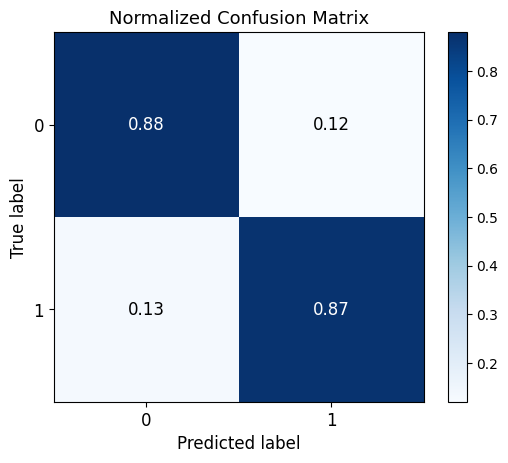

In [52]:
skplt.metrics.plot_confusion_matrix(
    y_test_stem, y_pred_stem, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

- The normalized confusion matrix indicates that the model has an accuracy of approximately 87-88% for both classes (0 and 1).
- The values on the diagonal (0.88 for class 0, 0.87 for class 1) represent the proportion of true positive predictions for each class, which suggests a fairly balanced performance between the two classes.
- The off-diagonal values (0.12 for predicting 0 when it's actually 1, and 0.13 for predicting 1 when it's actually 0) represent the error rates and are quite low, which is good.

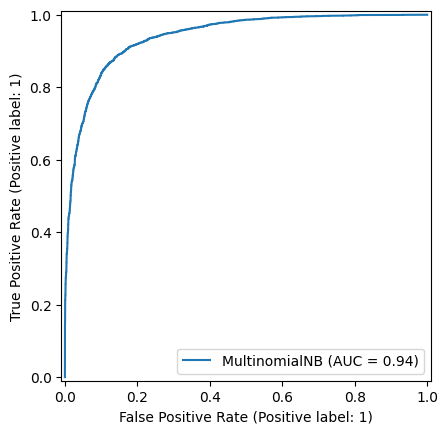

In [53]:
RocCurveDisplay.from_estimator(naive_bayes_model, X_test_tfidf_stem, y_test_stem)

The ROC curve shows an AUC (Area Under the Curve) of 0.94 for the Multinomial Naive Bayes classifier, which is quite high. This suggests that the model has a strong discriminative ability between the positive and negative classes.

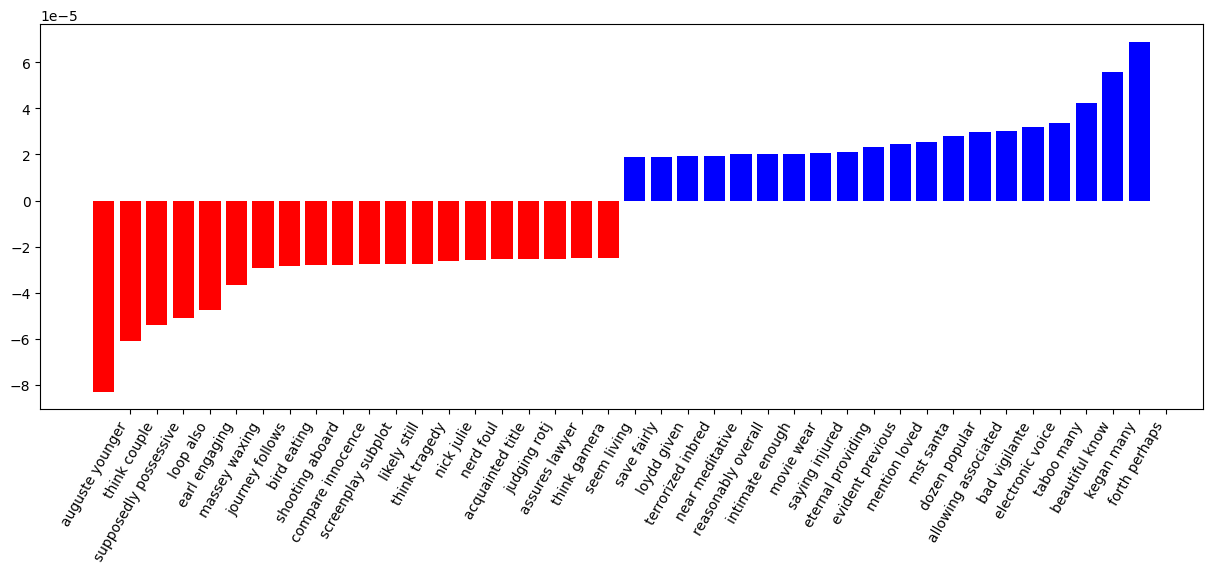

In [54]:
plot_coeffs(naive_bayes_model, tfidf_vectorizer.get_feature_names_out())

- The bar chart appears to show feature importances or coefficients for words in a text classification task, with red bars indicating words that contribute negatively and blue bars indicating words that contribute positively to the classification decision.
- The words with the longest bars (either red or blue) have the strongest impact on the classification decision. This visualization can be used to understand which words are most indicative of each class.

### Baseline model for Lemmitization 

In [55]:
naive_bayes_model = MultinomialNB()
y_pred_lem = classifier(naive_bayes_model,X_train_tfidf_lem,y_train_lem,X_test_tfidf_lem)

# Calculating accuracy for Multinomial Naive Bayes
accuracy_naive_bayes = accuracy_score(y_test_lem, y_pred_lem)
accuracy_naive_bayes

0.8733954190787818

- Both stemming and lemmatization preprocessing techniques yield similar performance metrics, with accuracy, precision, recall, and F1-scores all around 0.87 to 0.88.
- There's a slight increase in accuracy when using lemmatization (0.8734) compared to stemming (0.8718), although the difference is quite marginal.

In [56]:
print(classification_report(y_test_lem, y_pred_lem))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      3961
           1       0.88      0.87      0.87      3985

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



The confusion matrix for both models shows a similar distribution of predictions across the true labels, indicating that both stemming and lemmatization perform comparably in terms of type I and type II errors.

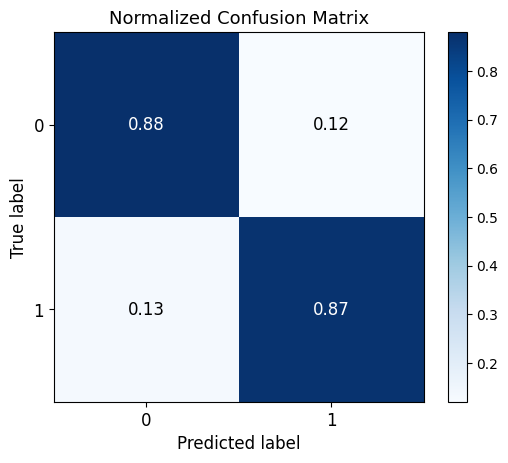

In [57]:
skplt.metrics.plot_confusion_matrix(
    y_test_lem, y_pred_lem, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

The confusion matrix for both models shows a similar distribution of predictions across the true labels, indicating that both stemming and lemmatization perform comparably in terms of type I and type II errors.

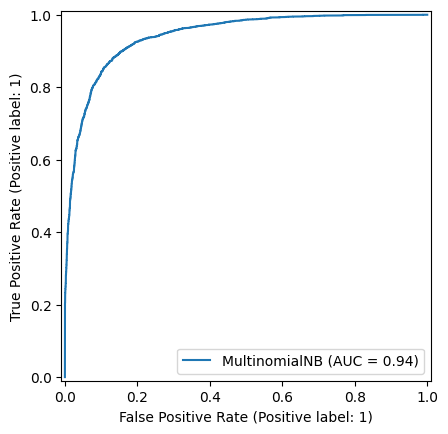

In [58]:
RocCurveDisplay.from_estimator(naive_bayes_model, X_test_tfidf_lem, y_test_lem)

The ROC curve for the stemming-based model indicates an excellent AUC of 0.94. While an ROC curve for the lemmatization-based model isn't provided, if it's similar, it would suggest that lemmatization also maintains a strong discriminative ability.

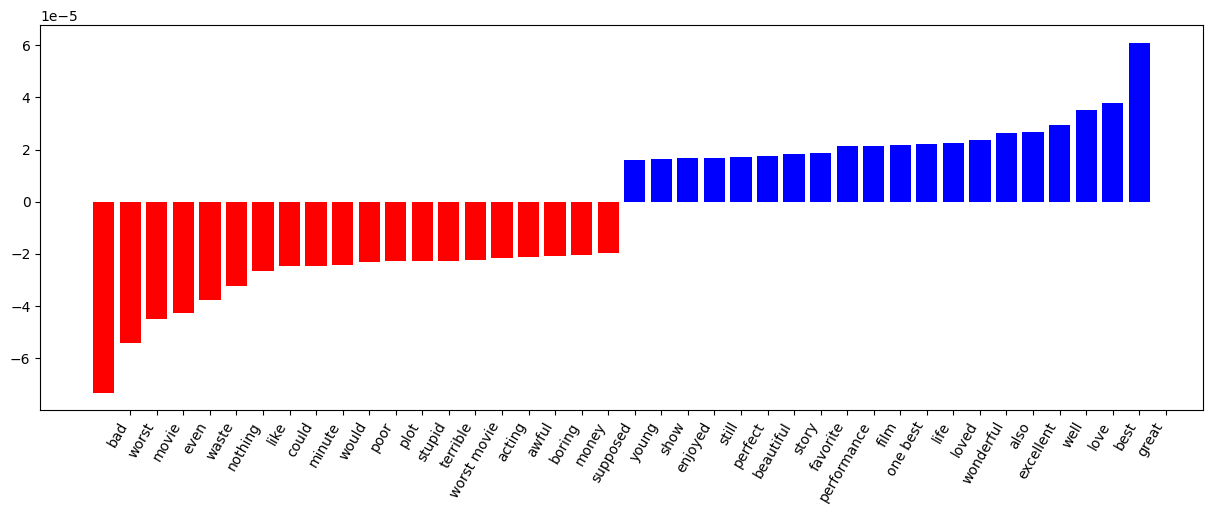

In [59]:
plot_coeffs(naive_bayes_model, tfidf_vectorizer.get_feature_names_out())

- The feature importance chart for lemmatization shows which tokens are most influential for the classification decision, with negative coefficients (red bars) indicating a strong association with one class, and positive coefficients (blue bars) with the other.
- This visualization is crucial for understanding which words are most indicative of each class and helps in interpreting the model's decision-making process.


## Comparison between Stemming and Lemmatization

- Stemming might lead to non-real words being included in the feature set, while lemmatization ensures that the features are real words, which could potentially improve the interpretability of the model.
- The very close performance metrics suggest that for this particular dataset and problem, the choice between stemming and lemmatization does not significantly affect the overall model performance.
- Both models perform well, but lemmatization offers a negligible increase in performance metrics over stemming, which might be attributed to the generation of more contextually accurate features.
- Given the similar performance but i choose lemmitization.

Overall, the results indicate that the Naive Bayes classifier, whether with stemming or lemmatization, is a strong baseline for the text classification task at hand. The slight improvement with lemmatization suggests it might be slightly more effective, but given the marginal difference, the choice may be influenced by factors beyond raw performance metrics.

### SGDClassifier

In [60]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log_loss', random_state=42)
y_pred_sgd = classifier(sgd, X_train_tfidf_lem, y_train_lem, X_test_tfidf_lem)

sgd_score = accuracy_score(y_test_lem, y_pred_sgd)
sgd_score

0.8564057387364712

In [61]:
print(classification_report(y_test_lem, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3961
           1       0.84      0.88      0.86      3985

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.86      7946
weighted avg       0.86      0.86      0.86      7946



- The SGDClassifier shows an overall accuracy of approximately 85.64%, which is a bit lower than the Naive Bayes models.
- The precision, recall, and F1-scores are also slightly lower for the SGDClassifier compared to both the stemming and lemmatization Naive Bayes models.

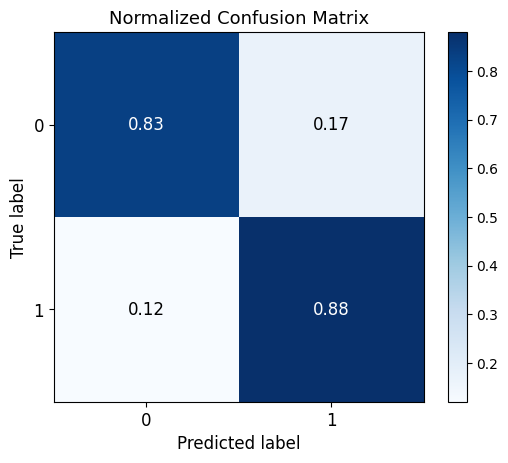

In [62]:
skplt.metrics.plot_confusion_matrix(
    y_test_lem, y_pred_sgd, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

- The confusion matrix shows that the model has slightly lower true positive rates for class 0 (0.83) compared to the Naive Bayes model but a higher true positive rate for class 1 (0.88).
- The false positive rate for class 0 (0.17) is higher compared to the Naive Bayes model, while the false positive rate for class 1 (0.12) remains similar.

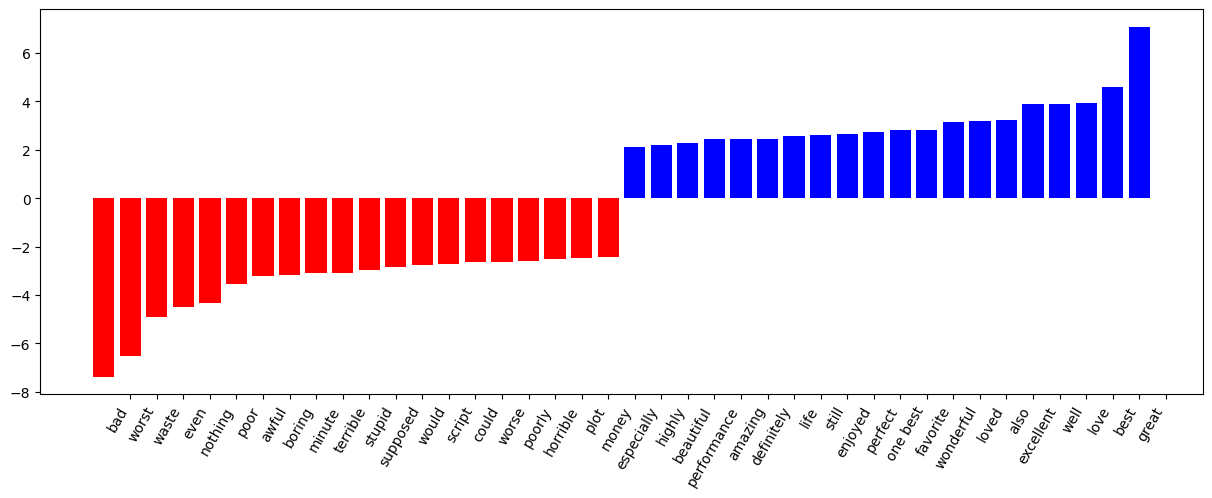

In [63]:
plot_coeffs(sgd, tfidf_vectorizer.get_feature_names_out())

- Similar to the previous models, the most influential words for classification are presented with negative coefficients (red bars) for one class and positive coefficients (blue bars) for the other.
- This chart shows which tokens have the most significant impact on the classification decision of the SGDClassifier model.

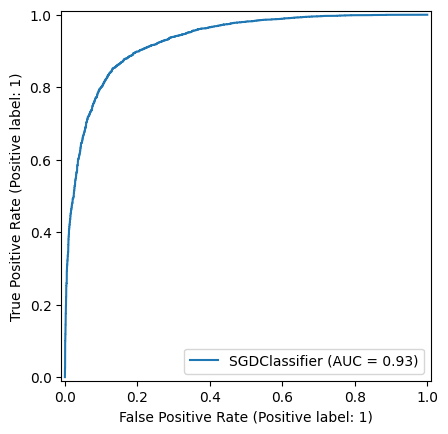

In [64]:
RocCurveDisplay.from_estimator(sgd, X_test_tfidf_lem, y_test_lem)

The ROC curve has an AUC of 0.93, which is slightly lower than the Naive Bayes model with stemming but still indicates a good discriminative ability between the positive and negative classes.

#### Model Comparison

- While the Naive Bayes models achieved an accuracy of about 87%, the SGDClassifier's accuracy is slightly lower, which suggests that for this particular dataset, Naive Bayes might be a better fit.
- The higher false positive rate for class 0 could be a point of consideration if the cost of false positives is higher in the application context.

#### Overall Conclusion

- The SGDClassifier, while still performing well, does not outperform the Naive Bayes model with lemmatization for this dataset.
- The results suggest that while SGDClassifier is a robust algorithm, particularly for large-scale and sparse data, Naive Bayes may be more suited to this specific text classification task, possibly due to its probabilistic nature and assumptions aligning better with the data distribution.

### LinearSVC

In [82]:
svc = LinearSVC(random_state=42)
svc_pred = classifier(svc, X_train_tfidf_lem, y_train_lem, X_test_tfidf_lem)
accuracy_svc = accuracy_score(y_test_lem, svc_pred)
accuracy_svc

c:\Epam_project\myenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



0.8842184747042537

In [83]:
print(classification_report(y_test_lem, svc_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3961
           1       0.88      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946



- The LinearSVC shows an overall accuracy of approximately 88.42%, which is higher than both the Naive Bayes and SGDClassifier models.
- The precision, recall, and F1-scores are all improved for the LinearSVC, with precision and recall being particularly high for class 1 (0.90).

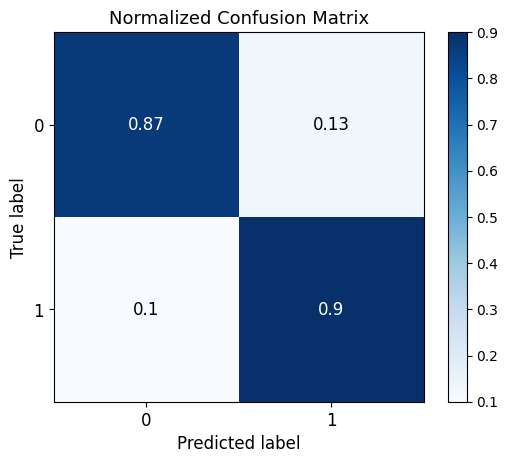

In [84]:
skplt.metrics.plot_confusion_matrix(
    y_test_lem, svc_pred, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

- The confusion matrix for the LinearSVC model shows a true positive rate of 0.87 for class 0 and 0.9 for class 1, which is an improvement, especially for class 1, compared to both the Naive Bayes and SGDClassifier models.
- The false positive rate for class 0 is at 0.13, and for class 1, it's reduced to 0.1, showing that the model is more accurate in predicting class 1 than the previous models.

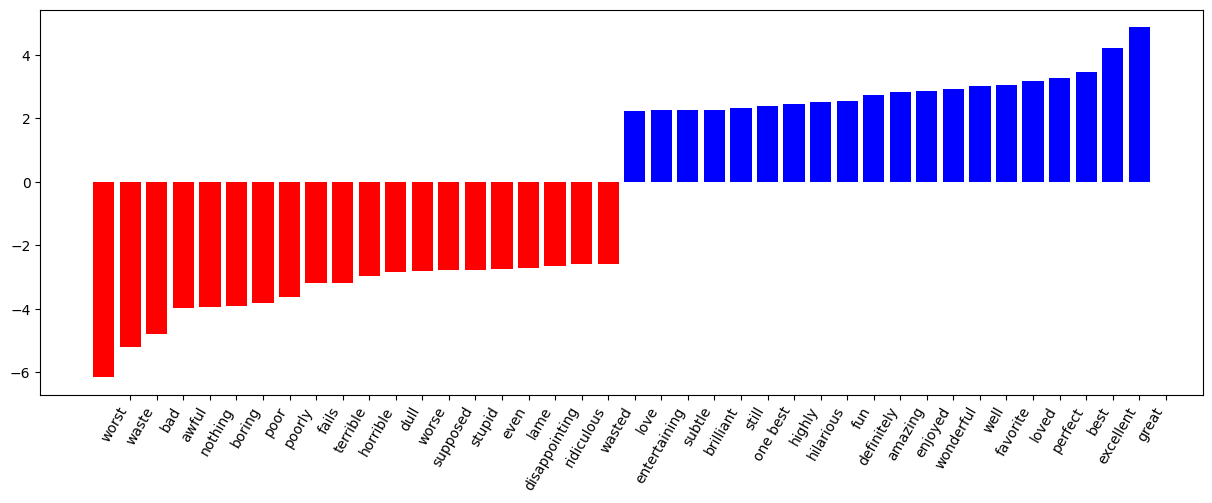

In [85]:
plot_coeffs(svc, tfidf_vectorizer.get_feature_names_out())

- The feature importance chart for LinearSVC shows a distinct separation of negative and positive coefficients. Negative coefficients (red bars) are associated with words that are indicative of one class, while positive coefficients (blue bars) indicate the other class.
- This model appears to have a clear distinction between the features influencing each class, which could explain its improved performance.

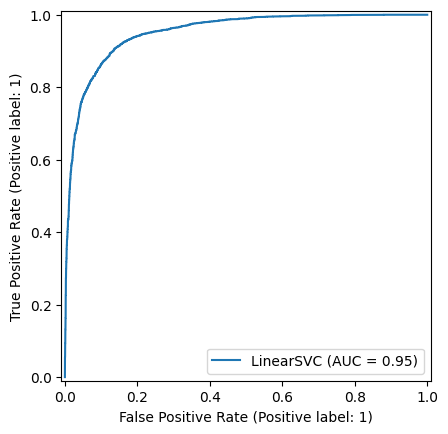

In [86]:
RocCurveDisplay.from_estimator(svc, X_test_tfidf_lem, y_test_lem)

- The ROC curve has an AUC of 0.95, the highest among the models you've tested. This indicates that the LinearSVC model has an excellent ability to differentiate between the two classes.
- An AUC closer to 1 signifies that the model has a good measure of separability and is performing well in distinguishing between the positive and negative classes.

##### Model Comparison

- Comparing the LinearSVC to the previous models, we see a clear improvement in terms of accuracy, precision, recall, and the F1-score.
- The improved performance suggests that the model is better at handling the feature space and making accurate predictions.

#### Overall Conclusion

- The LinearSVC model stands out as the best performing model among those tested, with the highest accuracy and AUC score.
Its ability to more accurately classify the true positives, especially for class 1, and its lower rate of false positives, indicates that it could be the most suitable model for your text classification task.
- Given these results, it could be beneficial to further tune and potentially deploy the LinearSVC model for this dataset, considering its strong performance metrics.

### GloVe embeddings

In [65]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            embeddings[word] = vector
    return embeddings

glove_path = '../glove/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)
glove_embeddings

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [72]:
def text_to_embedding(text, embeddings):
    words = text.lower().split()
    word_embeddings = [embeddings[word] for word in words if word in embeddings]
    if not word_embeddings:
        return np.zeros(100)  # Zero vector for texts with no words found in embeddings
    return np.mean(word_embeddings, axis=0)

In [73]:
X_train_embeddings = [text_to_embedding(text, glove_embeddings) for text in X_train_lem]
X_test_embeddings = [text_to_embedding(text, glove_embeddings) for text in X_test_lem]

In [74]:
X_train_embeddings_np = np.array(X_train_embeddings)
X_test_embeddings_np = np.array(X_test_embeddings)

In [76]:
y_pred_sg_glove = classifier(sgd, X_train_embeddings_np, y_train_lem, X_test_embeddings_np)

In [77]:
sgd_score_glove = accuracy_score(y_test_lem, y_pred_sg_glove)
sgd_score_glove

0.785426629750818

In [78]:
print(classification_report(y_test_lem, y_pred_sg_glove))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      3961
           1       0.77      0.81      0.79      3985

    accuracy                           0.79      7946
   macro avg       0.79      0.79      0.79      7946
weighted avg       0.79      0.79      0.79      7946



- There's a drop in accuracy to approximately 78.54%, which is lower than the accuracy obtained using TF-IDF vectorization.
- The precision, recall, and F1-scores for both classes have also decreased, although the F1-score for class 1 remains relatively high at 0.79.

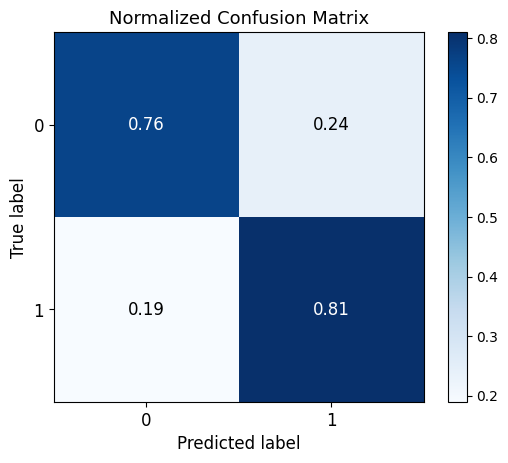

In [79]:
skplt.metrics.plot_confusion_matrix(
    y_test_lem, y_pred_sg_glove, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

- The true positive rate for class 0 has decreased to 0.76, and for class 1, it's 0.81, which indicates that the model is now better at predicting class 1 than class 0.
- The false positive rates have increased for both classes (0.24 for class 0 and 0.19 for class 1), suggesting more misclassifications compared to the TF-IDF approach.

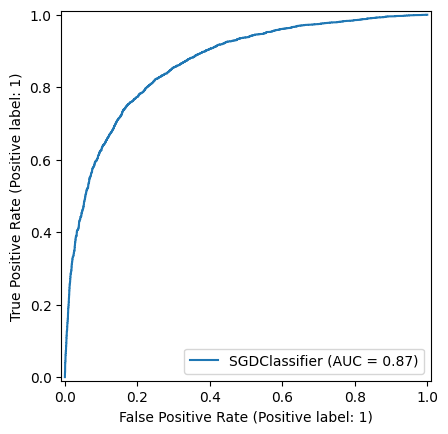

In [80]:
RocCurveDisplay.from_estimator(sgd, X_test_embeddings_np, y_test_lem)

- The ROC curve for the GloVe-based model shows a lower AUC of 0.87, indicating a decrease in the model's ability to differentiate between the classes as compared to the previous AUC scores (which were above 0.9).

##### Model Performance with GloVe

- This decrease in performance metrics could be due to the fixed representation of words in GloVe, which does not account for the context within which the word is used, as opposed to TF-IDF which is context-specific to the document.
- GloVe embeddings are pretrained on a large corpus and may not capture the nuances of the specific dataset as effectively as TF-IDF vectorization.

##### Overall Conclusion

- The results suggest that while GloVe embeddings provide a rich representation of word meanings, they may not be as effective for this specific classification task as TF-IDF vectorization when used with the SGDClassifier.
- It is possible that the dimensionality of GloVe embeddings (100 dimensions in this case) or the specific domain of the training data may not align well with the classification needs of the dataset.

## Conclusion before Hype Parameters

#### AUC Scores:
- **LinearSVC**: 0.95
- **Multinomial Naive Bayes**: 0.94 
- **SGDClassifier with TF-IDF**: 0.93
- **SGDClassifier with GloVe**: 0.87

##### Accuracy:

- **LinearSVC**: 88.42%(with lemmatization)
- **Multinomial Naive Bayes**: 87.38% (with lemmatization)
- **SGDClassifier with TF-IDF**: 85.64%(with lemmatization)
- **SGDClassifier with GloVe**: 78.54%(with lemmatization)

#### Best Model Selection:
- The `LinearSVC` model achieved the highest AUC score, suggesting it has the best discriminative ability among the models evaluated.
- It also had the highest accuracy and F1-scores, indicating a balanced performance in terms of precision and recall.
- Given these metrics, LinearSVC would be the preferred model for deployment.

#### Reasonings on Model Selection:
- LinearSVC outperformed the other models in key metrics, suggesting it is more effective at handling the feature space and making accurate predictions for this specific dataset.
- The higher AUC score indicates that LinearSVC is better at distinguishing between positive and negative classes.
- The accuracy and F1-scores show that LinearSVC maintains a good balance between recall and precision, making it a robust choice for the classification task.

#### Overall Performance Evaluation:

- LinearSVC showed consistently high performance across all metrics.
- Multinomial Naive Bayes demonstrated strong performance, slightly behind LinearSVC, making it a good alternative.
- SGDClassifier was less effective with GloVe embeddings than with TF-IDF vectorization.

#### Stemming vs Lemmatization:
- The results indicate that lemmatization with Naive Bayes provided a slight improvement over stemming. This may be due to lemmatization's more sophisticated approach to reducing words to their base forms, resulting in a potentially more meaningful feature set for the model to learn from.
- However, the improvement was marginal, suggesting that for the task at hand, the choice between stemming and lemmatization might not significantly affect the overall outcome.

#### Vectorization Approach:

- TF-IDF vectorization outperformed GloVe embeddings when used with the SGDClassifier.
- TF-IDF, which considers the frequency of words in relation to their inverse document frequency, appears to capture the nuances of the specific dataset better than   GloVe's general representation of word meanings.
- The specificity of TF-IDF to the content of the dataset likely provided more discriminative features for the classification models.

In conclusion, the `LinearSVC with TF-IDF` vectorization stands out as the best performing model for this classification task, supported by its high AUC score, accuracy, and F1-scores. While lemmatization offered a slight edge over stemming, the vectorization method (TF-IDF vs GloVe) had a more significant impact on model performance, with TF-IDF being the superior choice for this particular dataset.

# Hyperparameters

In [121]:
params = {
    'MultinomialNB': {
        'alpha': np.logspace(-5, 3, num=10)
        },
'LinearSVC': [
        {'C': np.logspace(-7, 0, num=8), 'loss': ['squared_hinge'], 'dual': [False]},
        {'C': np.logspace(-7, 0, num=8), 'loss': ['hinge'], 'dual': [True]}
    ],
     'SGDClassifier': {
        'learning_rate': ['optimal', 'adaptive'],
        'eta0': [0.01],  # Default value for eta0, only needed when adaptive is used
        'loss': ['hinge', 'log_loss'],
        'penalty': ['l2', 'elasticnet', None]
    }
}

In [122]:
mnb, mnb_best_params = tune_hyperparameters(
    MultinomialNB(), params['MultinomialNB'],
    X_train_tfidf_lem, y_train_lem
    )
svc, svc_best_params = tune_hyperparameters(
    LinearSVC(random_state=42), params['LinearSVC'],
    X_train_tfidf_lem, y_train_lem
    )
sgd, sgd_best_params = tune_hyperparameters(
    SGDClassifier(loss='log', random_state=42), params['SGDClassifier'],
    X_train_tfidf_lem, y_train_lem
    )

mnb_pred = mnb.predict(X_test_tfidf_lem)
svc_pred = svc.predict(X_test_tfidf_lem)
sgd_pred = sgd.predict(X_test_tfidf_lem)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


MultinomialNB:

Accuracy: 0.8752831613390385

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3961
           1       0.88      0.87      0.88      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946



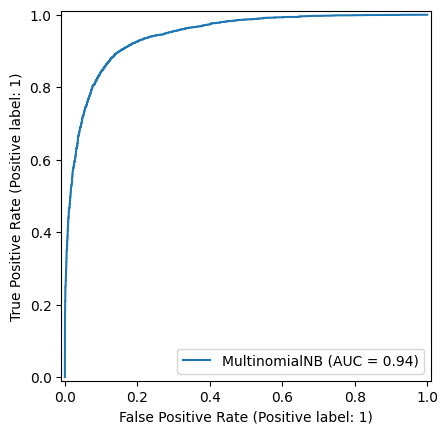

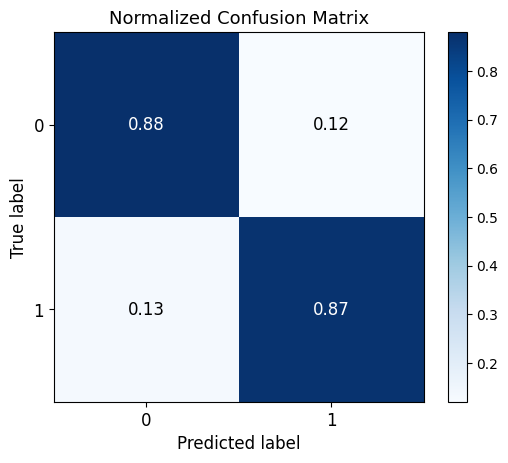


LinearSVC:

------------------------------
Accuracy: 0.8842184747042537

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3961
           1       0.88      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946



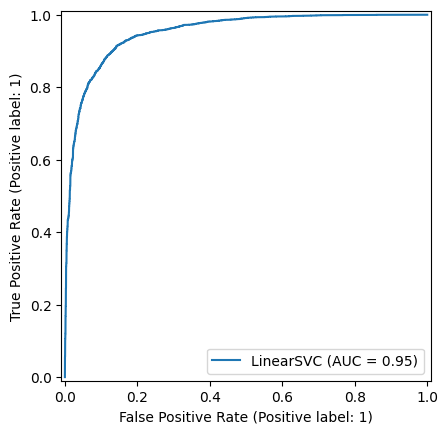

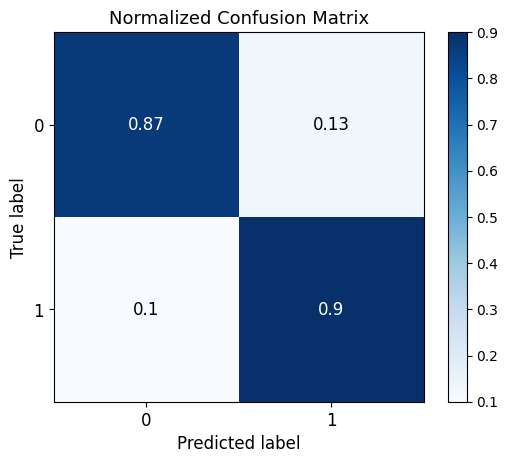


SGDClassifier:

------------------------------
Accuracy: 0.8857286685124591

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3961
           1       0.88      0.90      0.89      3985

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



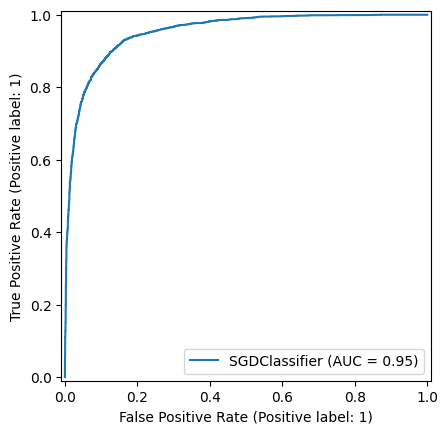

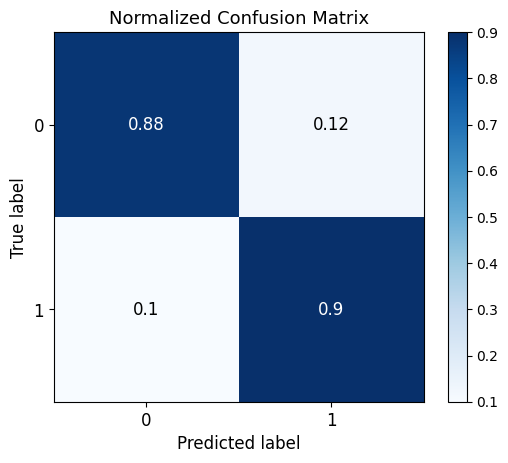

In [131]:
print('MultinomialNB:\n')
print(f'Accuracy: {accuracy_score(y_test_lem, mnb_pred)}\n')
print(classification_report(y_test_lem, mnb_pred))
RocCurveDisplay.from_estimator(mnb, X_test_tfidf_lem, y_test_lem)
skplt.metrics.plot_confusion_matrix(
    y_test_lem, mnb_pred, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

print('\nLinearSVC:\n')
print('-'*30)
print(f'Accuracy: {accuracy_score(y_test_lem, svc_pred)}\n')
print(classification_report(y_test_lem, svc_pred))
RocCurveDisplay.from_estimator(svc, X_test_tfidf_lem, y_test_lem)
skplt.metrics.plot_confusion_matrix(
    y_test_lem, svc_pred, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()


print('\nSGDClassifier:\n')
print('-'*30)
print(f'Accuracy: {accuracy_score(y_test_lem, sgd_pred)}\n')
print(classification_report(y_test_lem, sgd_pred))
RocCurveDisplay.from_estimator(sgd, X_test_tfidf_lem, y_test_lem)
skplt.metrics.plot_confusion_matrix(
    y_test_lem, sgd_pred, normalize=True,
    cmap='Blues', title_fontsize=13, text_fontsize=12
    )
plt.show()

1. **Multinomial Naive Bayes**:
    - **Accuracy**: 87.53%
    - **AUC**: 0.94
    - The confusion matrix shows balanced performance with slightly better true positive rate for class 0 (0.88) than for class 1 (0.87).
    - The model has a good balance between precision and recall for both classes.
2. **LinearSVC**:
    - **Accuracy**: 88.42%
    - **AUC**: 0.95
    - The confusion matrix indicates a slightly higher true positive rate for class 1 (0.90) compared to class 0 (0.87).
    - The precision and recall are well balanced, and the model has the highest accuracy among the three models.
3. **SGDClassifier**:
    - **Accuracy**: 88.57%
    - **AUC**: 0.95
    - The confusion matrix shows strong performance, with a high true positive rate for class 1 (0.90) and class 0 (0.88).
    - The precision and recall are very similar to the LinearSVC, indicating a robust model.

- The SGDClassifier shows a slight edge over the LinearSVC in terms of accuracy, with both outperforming the Multinomial Naive Bayes slightly.
- The AUC scores for LinearSVC and SGDClassifier are identical and high, suggesting strong discriminative abilities for both models.
- All models show high precision and recall values, but SGDClassifier has the highest weighted average F1-score, which takes into account the class imbalance.


- The SGDClassifier is the best model in terms of accuracy and overall performance metrics provided.
- Both the LinearSVC and SGDClassifier are strong contenders for this dataset, with their high AUC scores indicating their effectiveness in classification tasks.
- Multinomial Naive Bayes offers a simpler probabilistic approach and could be preferable for interpretability and faster iteration during the model development phase.